# 1. Підключення основних бібліотек та завантаження даних

In [5]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
%matplotlib inline

In [2]:
df = pd.read_csv('cookie_cats.csv')

In [3]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [8]:
df.describe()

,userid,sum_gamerounds
count,9.018900e+04,90189.000000
mean,4.998412e+06,51.872457
std,2.883286e+06,195.050858
min,1.160000e+02,0.000000
25%,2.512230e+06,5.000000
50%,4.995815e+06,16.000000
75%,7.496452e+06,51.000000
max,9.999861e+06,49854.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


Вибірка немає пропущених значень, складається із 90189 об'єктів, які мають 4 ознаки. Покзаники утримання мають булевий тип даних, тому його для зручності можна буде перевести у бінарний числовий тип.

# 2.Попередній огляд даних

<AxesSubplot:ylabel='sum_gamerounds'>

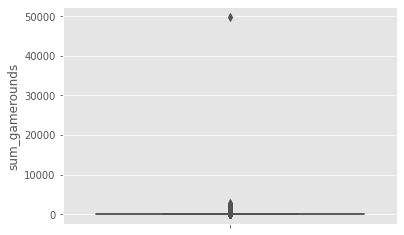

In [7]:
sns.boxplot(y = df['sum_gamerounds'])

Як бачимо, наявне одне аномальне значення, яке близьке до 50000 раундів

Переглянемо розподіл кількості проведених раундів в грі

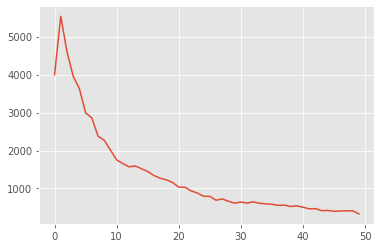

In [133]:
x = df.groupby(by = ['sum_gamerounds']).count()
plt.plot(x.index[:50], x.userid[:50])

На графіку можна побачити швидке зростання до максимального значення, а даліше експонеційне зменшення кількості проведеного часу в грі.

Розподіл кількості раундів проведених в грі в різних вибірках в логарифмічній шкалі

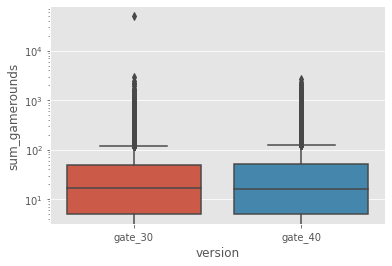

In [110]:
fig = plt.figure()
ax = fig.add_subplot()
sns.boxplot(x = df['version'], y = df['sum_gamerounds'])
ax.set_yscale('log')

Переведемо булевий формат даних в бінарний числовий

In [27]:
df = df.replace([True, False], [1, 0])

In [28]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,0,0
1,337,gate_30,38,1,0
2,377,gate_40,165,1,0
3,483,gate_40,1,0,0
4,488,gate_40,179,1,1


Порівняємо середні значення одноденного та семиденного утримання гравців при різних версіях заставки, а також кількість зіграних раундів

In [30]:
df.groupby('version').mean()

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,4.987564e+06,52.456264,0.448188,0.190201
gate_40,5.009073e+06,51.298776,0.442283,0.182000


<AxesSubplot:xlabel='version'>

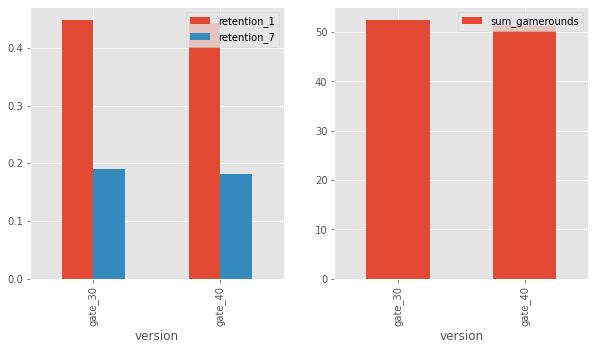

In [145]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 5))

df.groupby('version').mean()[['retention_1' ,'retention_7']].plot(kind = 'bar', ax = ax1)
df.groupby('version').mean()[['sum_gamerounds']].plot(kind = 'bar', ax = ax2)

В 'gate_30' більше утримання та більше сумарна кількість проведених раундів в грі

# 3.1 Перевіримо чи існує статистична різниця в одноденному утримані

Для дослідження буде використаний метод Монте-Карло. Змоделюємо нові дані шляхом створення 700 нових вибірок випадковим вибором даних із уже існуючої вибірки і порівнянням середніх значень нових вибірок.

Візуалізуємо з використанням ядерної оцінки густини.

In [99]:
df.sample(frac=1, replace=True).groupby('version')['retention_1'].mean()

version
gate_30    0.448826
gate_40    0.444224
Name: retention_1, dtype: float64

<AxesSubplot:ylabel='Density'>

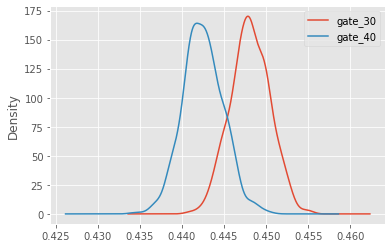

In [100]:
boot_1d = []
for i in range(700):
    boot_mean = df.sample(frac=1, replace=True).groupby('version')['retention_1'].mean()
    boot_1d.append(boot_mean)
    
boot_1d = pd.DataFrame(boot_1d, columns=['gate_30', 'gate_40'])
    
boot_1d.plot(kind = 'kde')



На графіку є суттєва різниця між двома розподілами. Перевіримо їхній розподіл на нормальність та використаємо тест Стьюдента для перевірки рівності середніх значень.

In [150]:
from scipy.stats import ttest_ind
from scipy import stats
stat, p = ttest_ind(boot_1d['gate_30'], boot_1d['gate_40'])
p40 = stats.shapiro(boot_1d['gate_40']).pvalue
print('Тест Шапіро-Уілка для \'gate_40\' p=%.3f' % (p40))
p30 = stats.shapiro(boot_1d['gate_30']).pvalue
print('Тест Шапіро-Уілка для \'gate_30\' p=%.3f' % (p30))
print('t=%.3f, p=%.3f' % (stat, p))

Тест Шапіро-Уілка для 'gate_40' p=0.262
Тест Шапіро-Уілка для 'gate_30' p=0.920
t=44.364, p=0.000


In [155]:
anderson = stats.anderson(boot_1d['gate_40'])
print(anderson)

AndersonResult(statistic=0.6221921106832724, critical_values=array([0.573, 0.652, 0.783, 0.913, 1.086]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))


In [156]:
anderson = stats.anderson(boot_1d['gate_30'])
print(anderson)

AndersonResult(statistic=0.22751082420768398, critical_values=array([0.573, 0.652, 0.783, 0.913, 1.086]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))


P-значення тесту Стьюденту є меншим за всі популярні рівні значимості, тому можна відхилити гіпотезу рівності середніх значень. Але вибірку не можна вважати нормальною, лише критерій Андерсона для 'gate_40' дає змогу вважати, що на рівні значимості 15% вибірка є нормальною.

Тому також проведений тест Манна-Уітні для рівності медіан, який також вказує на відмінності у вибірках.

In [154]:
stat, p = stats.mannwhitneyu(boot_1d['gate_30'], boot_1d['gate_40'])
print('stat=%.3f, p=%.5f' % (stat, p))

stat=23768.000, p=0.00000


# 3.2 Перевіримо чи існує статистична різниця в тижневому утримані

Повторимо аналогічні дії для тижневого утримання

<AxesSubplot:ylabel='Density'>

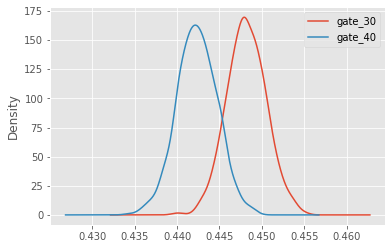

In [157]:
boot_7d = []
for i in range(700):
    boot_mean = df.sample(frac=1, replace=True).groupby('version')['retention_1'].mean()
    boot_7d.append(boot_mean)
    
boot_7d = pd.DataFrame(boot_7d, columns=['gate_30', 'gate_40'])
    
boot_7d.plot(kind = 'kde')

In [158]:
stat, p = ttest_ind(boot_7d['gate_30'], boot_7d['gate_40'])
p40 = stats.shapiro(boot_7d['gate_40']).pvalue
print('Тест Шапіро-Уілка для \'gate_40\' p=%.3f' % (p40))
p30 = stats.shapiro(boot_1d['gate_30']).pvalue
print('Тест Шапіро-Уілка для \'gate_30\' p=%.3f' % (p30))
print('t=%.3f, p=%.3f' % (stat, p))

Тест Шапіро-Уілка для 'gate_40' p=0.841
Тест Шапіро-Уілка для 'gate_30' p=0.920
t=46.592, p=0.000


In [159]:
anderson = stats.anderson(boot_7d['gate_40'])
print(anderson)

AndersonResult(statistic=0.22946887325906573, critical_values=array([0.573, 0.652, 0.783, 0.913, 1.086]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))


In [160]:
anderson = stats.anderson(boot_7d['gate_30'])
print(anderson)

AndersonResult(statistic=0.1770586005337691, critical_values=array([0.573, 0.652, 0.783, 0.913, 1.086]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))


In [162]:
stat, p = stats.mannwhitneyu(boot_7d['gate_30'], boot_7d['gate_40'])
print('stat=%.3f, p=%.5f' % (stat, p))

stat=18921.000, p=0.00000


В тижневомі утриманні маємо аналогічну ситуацію. Відкидаємо гіпотезу нормальності, рівності середніх значень та рівності медіан вибірок.

# 4. Висновки

При проведенні аналізу встановлено, що 'gate_30' має кращий ефект в короткотривалому та довготривалому утриманні гравців, а також у кількості зіграних ігор ніж 'gate_40'.